In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import time
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException



# Part 1: Analyze the Fake News Dataset


## 1.1: Import dataset from Ex 1

In [46]:
#load data
dataPath = "data/"
Cleaned_data = pd.read_csv(dataPath + "cleanedData.csv")

## 1.2 Dataset Analysis

### Determine which article types should be omitted, if any.


In [47]:
typelist = Cleaned_data['type'].unique()
print(typelist)

['unreliable' 'fake' 'clickbait' 'conspiracy' 'reliable' 'bias' 'hate'
 'junksci' 'political' nan 'unknown']


Assuming that the data will be used to train a classifier such as the one in the course project, there are some types that should be omitted. These are the ones that are note certainly either fake or reliable. If a type cant be given one of our two labels they cannot be used for training.

    Unknown: If we dont know the article type it, cant be placed in either label.

    nan: Omitted for same reason as unknown

    Unreliable: The documentation describes it as "Sources that may be reliable but whose contents require further verification." Which may as well be unknown, and will thus be ommitted for the same reasons as above.

In [48]:
Cleaned_data = Cleaned_data.dropna(subset=['type'])
Cleaned_data = Cleaned_data.loc[Cleaned_data['type']!='unknown']
Cleaned_data = Cleaned_data.loc[Cleaned_data['type']!='unreliable']

In [49]:
# Get the counts for each unique type
type_counts = Cleaned_data['type'].value_counts()

# Print the counts
for types, count in type_counts.items():
    print(types, ":", count)

fake : 155
conspiracy : 31
political : 23
bias : 6
junksci : 6
reliable : 3
clickbait : 1
hate : 1


### Group the remaining types into 'fake' and 'reliable'. Argue for your choice.

### Fake
    Fake           
    Conspiracy
    Bias
    Junksci
    Hate

From the documentaion it can be seen that Conspiracy, Hate, bias and junksci are mostly made up of statements misrepresenting fact or content that is either highly biased by or entirely based on belief. In either case content that is not backed by science or fact. Fake is fake
    
### Reliable
    Political
    Reliable
    Clickbait

Political and Clickbait are both described as generally reliable, with slight bias or inaccuracy. Reliable is reliable.

In [50]:
# groups (reliable) as truenews 1 and (all others) in fakenews 0 
    #note this is naive and should be reconsidered later
Cleaned_data['type'] = Cleaned_data['type'].replace({'^reliable$': '1', '^political$': '1', '^clickbait$': '1'}, regex=True)
Cleaned_data['type'] = Cleaned_data['type'].replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'



### Examine the percentage distribution of 'reliable' vs. 'fake' articles. Is the dataset balanced? Discuss the importance of a balanced distribution.

In [51]:
# Get the counts for each unique type
countFake, countReliable = Cleaned_data['type'].value_counts()
countTotal = countFake + countReliable

labels = ['fake', 'true']
PercentageValues = [countFake / countTotal * 100, countReliable / countTotal * 100]

percentage_df = pd.DataFrame({
    'Type': labels,
    'Percentage': PercentageValues
})

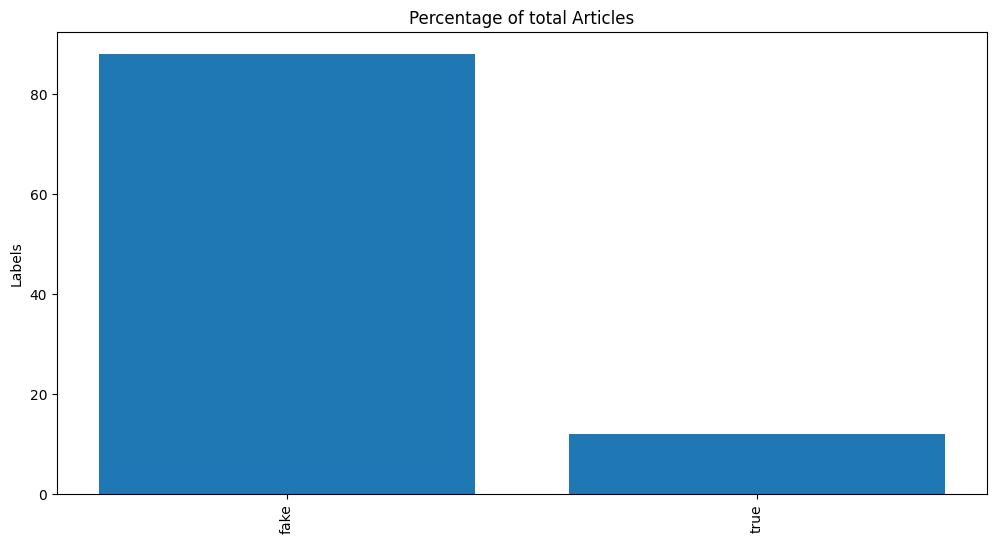

fake percentage: 88.05309734513274
reliable percentage: 11.946902654867257
relation: 7.37037037037037


In [52]:
fig, ax = plt.subplots(figsize=(12, 6)) 

ax.bar(percentage_df['Type'], percentage_df['Percentage'], color= 'tab:blue')

ax.set_ylabel('Labels')
ax.set_title('Percentage of total Articles')
plt.xticks(rotation=90)

plt.show()
print('fake percentage:',countFake / countTotal * 100)
print('reliable percentage:',countReliable / countTotal * 100)
print('relation:', countFake / countReliable)

The data is highly unbalanced in favor of fake articles, with a ratio of approximately 1:7. For a model to effectively learn the distinguishing features of each class, it is beneficial to expose it to an even distribution of both classes. In cases like ours, where one class dominates the data, a model trained on such an imbalanced dataset may become biased. It could overfit by learning the statistical advantage of predicting the majority class, rather than learning the distinct features that differentiate both classes. As a result, the model might predict the majority class disproportionately, regardless of the content, and fail to accurately identify the minority class.

# Part 2: Gathering Links


## 2.1: Install Library

dddddonn

## 2.2: Retrieve HTML Content

In [53]:

options = Options()
options.add_argument("-profile")
options.add_argument("/home/andreas-linus-thalund-midtgaard/snap/firefox/common/.mozilla/firefox/kao2pljk.default")  # Replace with your actual profile path

browser = webdriver.Firefox(options=options)
browser.get("https://www.bbc.com/news/world/europe")



In [54]:
#get html
html = browser.page_source
time.sleep(2)
print(html)

# close web browser
browser.close()

<html lang="en-GB"><head><meta charset="utf-8"><meta name="viewport" content="width=device-width"><title>Europe | Latest News &amp; Updates | BBC News</title><meta property="og:title" content="Europe | Latest News &amp; Updates | BBC News"><meta name="twitter:title" content="Europe | Latest News &amp; Updates | BBC News"><meta name="description" content="Get all the latest news, live updates and content about Europe from across the BBC."><meta property="og:description" content="Get all the latest news, live updates and content about Europe from across the BBC."><meta name="twitter:description" content="Get all the latest news, live updates and content about Europe from across the BBC."><meta name="msapplication-TileColor" content="#da532c"><meta name="theme-color" content="#ffffff"><meta name="robots" content="NOODP, NOYDIR"><meta name="apple-itunes-app" content="app-id=364147881, app-argument=https://www.bbc.com/news/world/europe"><link rel="apple-touch-icon" sizes="180x180" href="/bb

## 2.3 Extract Articles

In [201]:
def extractArticle():
    unique_articles = set()
    #retrieve the headline, the summary, and the link
    browser = webdriver.Firefox(options=options)
    browser.get("https://www.bbc.com/news/world/europe")
    time.sleep(2)

    #find divs containing headlines and summaries (articles) 
    articles = browser.find_elements(By.XPATH, "//div[count(.//h2) = 1 and .//p]")


    #Extract headlines and summaries from articles
    for article in articles:

        h2_element = article.find_element(By.XPATH, ".//h2")
        headline = h2_element.text.strip()       

        p_element = article.find_element(By.XPATH, ".//p")
        summary = p_element.text.strip()

        #move out of nested levels to closest <a> ancester (article link)
        a_element = article.find_element(By.XPATH, "./ancestor::a")  # Move up to find <a>
        link = a_element.get_attribute("href")
        
        # Convert relative links to absolute
        if link and link.startswith("/"):
            link = "https://www.bbc.com" + link

        #ensure no dublicates
        if not headline or not summary or not link:
            continue
        article_tuple = (headline, summary, link)
        if article_tuple not in unique_articles:
            unique_articles.add(article_tuple)
            print("\nArticle:")
            print("  Headline:", headline)
            print("  Summary:", summary)
            print("  Link:", lik)




    browser.quit()




In [206]:
def extractArticle():
    unique_articles = set()
    #retrieve the headline, the summary, and the link
    browser = webdriver.Firefox(options=options)
    browser.get("https://www.bbc.com/news/world/europe")
    time.sleep(2)

    #find link class containing headlines and summaries (articles) 
    articles = browser.find_elements(By.XPATH, "//a[count(.//h2) = 1 and .//p]")


    #Extract links, headlines and summaries from articles
    for article in articles:

        h2_element = article.find_element(By.XPATH, ".//h2")
        headline = h2_element.text.strip()       

        p_element = article.find_element(By.XPATH, ".//p")
        summary = p_element.text.strip()

        link = article.get_attribute("href")
        
        # Convert relative links to absolute
        if link and link.startswith("/"):
            link = "https://www.bbc.com" + link

        #ensure no dublicates
        if not headline or not summary or not link:
            continue
        article_tuple = (headline, summary, link)
        if article_tuple not in unique_articles:
            unique_articles.add(article_tuple)
            print("\nArticle:")
            print("  Headline:", headline)
            print("  Summary:", summary)
            print("  Link:", link)




    browser.quit()




In [207]:
extractArticle()


Article:
  Headline: Zelensky hopes US-Ukraine talks next week will be 'meaningful'
  Summary: The talks in Saudi Arabia come as both sides seek to heal a rift after presidents Zelensky and Trump clashed in public.
  Link: https://www.bbc.com/news/articles/cly2dz0qgxlo

Article:
  Headline: France has a nuclear umbrella. Could its European allies fit under it?
  Summary: President Macron has aired the idea that France's deterrence force could be used to defend of other European countries.
  Link: https://www.bbc.com/news/articles/c871e41751yo

Article:
  Headline: Five jailed over plot to kidnap German minister
  Summary: The group wanted to create civil war-like conditions in Germany and overthrow the government.
  Link: https://www.bbc.com/news/articles/cvg5vp8yj55o

Article:
  Headline: This city helped the US back Ukraine. Now its role is uncertain
  Summary: Scranton's ammunition plant makes weapons for Ukraine, and Zelensky paid it a visit last year.
  Link: https://www.bbc.com/

## 2.4 & 2.5: Web Scraping - Links

Function that scrapes the links for each article on all pages for all regions and saves to disk.

In [ ]:
def scrapeTheBBC():
    browser = webdriver.Firefox(options=options)
    browser.get("https://www.bbc.com/news/world/europe")
    time.sleep(1)

    unique_articles = set()

    linksToTheWorld = [
        "/news/us-canada", 
        "/news/uk", 
        "/news/world/africa", 
        "/news/world/asia", 
        "/news/world/australia", 
        "/news/world/latin_america", 
        "/news/world/middle_east"
    ]

    for link in linksToTheWorld:  
        while True:
                #scroll to bottom so paginator is loaded
                browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)

                #scrape data
                first_headline = browser.find_element(By.TAG_NAME, "h2").text.strip()
                print(first_headline)

                #find "next page" button and break loop if it does not excist
                next_buttons = browser.find_elements(By.XPATH, "//button[@data-testid='pagination-next-button']")
                if not next_buttons:
                    break

                next_button = next_buttons[0]
                if not next_button.is_enabled():
                    break
                
                #go to next page
                next_buttons[0].click()  
                time.sleep(2)
                
            
        browser.refresh() #refresh to get back to top
        time.sleep(2)
        
        #press next region link
        link_element = browser.find_element(By.XPATH, f"//a[contains(@href, '{link}')]")
        link_element.click()
        time.sleep(2)


    # close web browser
    browser.quit()


In [175]:
scrapeTheBBC()

Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Zelensky hopes US-Ukraine talks next week will be 'meaningful'
Next button is disabled, breaking!
Trump expands exemptions from Canada and Mexico tariffs
Trump expands exemptions from Canada and Mexico tariffs
Trump expands exemptions from Canada and Mexico tariffs
Trump expands exemptions from Canada and 

WebDriverException: Message: Failed to decode response from marionette


In [93]:
extracted_numbers = [int(num) for text in button_texts for num in re.findall(r'\d+', text)]


In [94]:
max([int(num) for text in button_texts for num in re.findall(r'\d+', text)])

12

# Part 3: Scraping Article Text


## 3.1

## 3.5: Will it make sense to include this data in the project?